In [1]:
import numpy as np
import simulator
import csv
import subprocess
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
genotype_dict = {"0/0" : 0,
                "0/1" : 1,
                "1/0" : 1,
                "1/1" : 2,
                "0/." : 0,
                "./0" : 0,
                "1/." : 2,
                "./1" : 2,
                "./." : -1}

def compare_VCF_sites(real_f, inferred_f, n_sites):
    real_f.seek(0)
    inferred_f.seek(0)
    true_reader = list(csv.reader(real_f, delimiter='\t'))
    call_reader = list(csv.reader(inferred_f, delimiter='\t'))
    TP = FN = TN = FP = 0
    #Sites only
    for true_line in true_reader:
        found = False
        #True Positive
        for call_line in call_reader:
            if call_line[0] == true_line[0] and call_line[1] == true_line[1]:
                TP += 1
                found = True
                break
        #False Negative
        if not found:
            FN += 1
    for call_line in call_reader:
        found = False
        #True Positive (again, not counting)
        for true_line in true_reader:
            if call_line[0] == true_line[0] and call_line[1] == call_line[1]:
                found = True
                break
        #False Positive
        if not found:
            FP += 1
    #True negatives
    TN = n_sites - TP - FN - FP
    precision = TP/(TP + FP)
    recall    = TP/(TP + FN)
    F1        = (2*TP)/(2*TP + FP + FN)
    return (precision, recall, F1)
    #return (TP,FN,FP,TN)
    

        
    

In [3]:
def compare_VCF_cells(real_f, inferred_f, n_sites):
    real_f.seek(0)
    inferred_f.seek(0)
    true_reader = list(csv.reader(real_f, delimiter='\t'))
    call_reader = list(csv.reader(inferred_f, delimiter='\t'))
    #Cells
    TP = FN = TN = FP = 0
    for i, field in enumerate(true_reader[0]):
        if field in genotype_dict.keys():
            first_cell_col_t = i
            break
    for i, field in enumerate(call_reader[0]):
        if field in genotype_dict.keys():
            first_cell_col_c = i
            break
    m = len(true_reader[0]) - first_cell_col_t
    for true_line in true_reader:
        found = False
        for call_line in call_reader:
            if call_line[0] == true_line[0] and call_line[1] == true_line[1]:
                #Correct site call found
                found = True
                for i in range(m):
                    if genotype_dict[true_line[first_cell_col_t + i]] > 0:
                        #Cell is really mutant
                        if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                            #And called correctly
                            TP += 1
                        else:
                            #Real mutant not called
                            FN += 1
                    else:
                        #Cell is welltype
                        if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                            #But called as mutant
                            FP += 1
                        else:
                            #Real wt called as wt
                            TN += 1
                break
        if not found:
            # Site mutant but not called
            for i in range(m):
                if genotype_dict[true_line[first_cell_col_t + i]] > 0:
                    #Cell actually mutant
                    FN += 1
                else:
                    TN += 1
    for call_line in call_reader:
        found = False
        for true_line in true_reader:
            if call_line[0] == true_line[0] and call_line[1] == call_line[1]:
                #Already dealt with correctly called sites above
                found = True
                break
        #Site called with no real mutation
        if not found:
            for i in range(m):
                if genotype_dict[call_line[first_cell_col_c + i]] > 0:
                    #Cell called mutant
                    FP += 1
    TN = m * n_sites - TP - FP - FN
    precision = TP/(TP + FP)
    recall    = TP/(TP + FN)
    F1        = (2*TP)/(2*TP + FP + FN)
    return (precision, recall, F1)

In [3]:
real_vcf = open("temp_r.vcf", "r")
call_vcf = open("temp_c.vcf", "r")
compare_VCF_cells(real_vcf, call_vcf, 2000)


FileNotFoundError: [Errno 2] No such file or directory: 'temp_r.vcf'

In [4]:
def test_params(m_cells, iters, params):
    site_results = []
    cell_results = []
    for i in range(iters):
        T = simulator.Phylogeny()
        T.evolve(n_generations=1000, germline=True)
        T.evolve(n_cells=5, germline=False)
        m = len(T.active_nodes)
        T.prepare()
        vcf_f = open("temp_r.vcf", "w+")
        T.write_vcf(vcf_f)
        vcf_f.close()
        pfile = open("temp.pileup", "w+")
        T.write_pileup(pfile)
        pfile.close()
        args = ["../SCarborSNV", "-m", str(m),"-p", "temp.pileup", "-o" "temp_c.vcf"]
        for name, val in params.items():
            args.append("--{}={}".format(name, val))
        subprocess.run(args)
        real_vcf = open("temp_r.vcf", "r")
        call_vcf = open("temp_c.vcf", "r")
        site_results.append(compare_VCF_sites(real_vcf, call_vcf, 2000))
        cell_results.append(compare_VCF_cells(real_vcf, call_vcf, 2000))
        real_vcf.close()
        call_vcf.close()
    os.remove("temp.pileup")
    os.remove("temp_r.vcf")
    os.remove("temp_c.vcf")
    return (site_results, cell_results)
        
    

In [5]:
test_params(6, 3, {"posterior-threshold": 0})

KeyboardInterrupt: 

In [ ]:
#Finding best thresholds with everything else default, 10 cells
posterior_threshs = [0.01,0.02] #[0, 1.0e-9, 1.0e-6, 1.0e-3, 5.0e-3, 0.01, 0.02, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1]
candidate_threshs = [0.5, 0.6] #[0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
site_data = pd.DataFrame(columns=["cand","post","precision","recall","F1"])
cell_data = pd.DataFrame(columns=["cand","post","precision","recall","F1"])
i = 0
for t1 in candidate_threshs:
    for t2 in posterior_threshs:
        prms = {}
        prms["candidate-threshold"] = t1
        prms["posterior-threshold"] = t2
        site_res, cell_res = test_params(4, 2, prms) #10, 10
        for j in range(2): #10
            site_data.loc[i] = [t1, t2, *site_res[j]]
            cell_data.loc[i] = [t1, t2, *cell_res[j]]
            i += 1
        

In [103]:
cell_data.to_csv("cell_data.csv", index=False)
site_data.to_csv("site_data.csv", index=False)


In [40]:
#After running full grid search on other machine
cell_results = pd.read_csv("cell_data.csv")
cand_results = cell_results.groupby(['cand']).mean().copy()
post_results = cell_results.groupby(['post']).mean().copy()

In [82]:
#argnames = ["lambda", "mu", "p-haploid", "p-clonal","pileup-file", "vcf-file","n-cells","temp-file","amp-err","p-ado","candidate-threshold","posterior-threshold"] 

,post,precision,recall,F1
cand,,,,
0.3,0.166857,0.822254,0.981761,0.878733
0.4,0.166857,0.824181,0.986261,0.882301
0.5,0.166857,0.824466,0.985259,0.882210
0.6,0.166857,0.834303,0.986659,0.889811
0.7,0.166857,0.830773,0.986161,0.887518
0.9,0.166857,0.814839,0.986065,0.874763


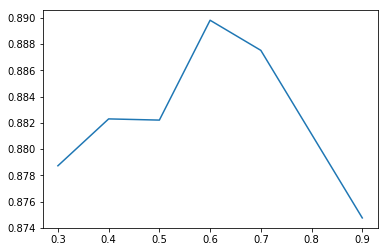

In [64]:
#After running all the above as a script to get csv files...
#This could be for an appendix on parameter tuning...
plt.plot([0.3,0.4,0.5,0.6,0.7,0.9], cand_results[['F1']])
cand_results
#After set best threshold should do this with more points around the max...

,cand,precision,recall,F1
post,,,,
1.000000e-03,0.6,0.866092,0.984522,0.912855
1.000000e-09,0.6,0.864872,0.985930,0.913488
0.000000e+00,0.6,0.862360,0.963760,0.904594
3.160000e-03,0.6,0.852831,0.986081,0.901402
3.160000e-01,0.6,0.851038,0.982398,0.901867
5.000000e-01,0.6,0.840359,0.984565,0.891538
1.000000e-02,0.6,0.839044,0.988187,0.893110
3.160000e-02,0.6,0.825885,0.988415,0.883110
1.000000e-01,0.6,0.824125,0.983978,0.878247


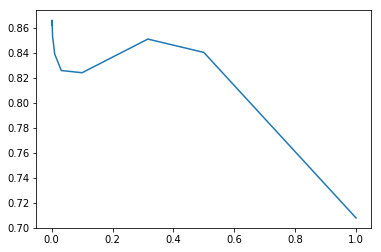

In [45]:
cell_results = pd.read_csv("result_data/posterior_threshold_cand0-6_m-10.csv")
post_results = cell_results.groupby(['post']).mean().copy()
post_x = [0, 1.0e-9, 1.0e-3, 3.16e-3, 1.0e-2, 3.16e-2, 1.0e-1, 3.16e-1, 0.5, 1]
fig = plt.figure()
ax = plt.gca()
ax.plot(post_x, post_results[['precision']].values)
post_results.sort_values(['precision'], ascending=False)